In [ ]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [6]:
!pip install nengo_dl

     |████████████████████████████████| 286kB 9.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 399kB 16.4MB/s 
  Created wheel for nengo-dl: filename=nengo_dl-3.3.0-cp36-none-any.whl size=197089 sha256=bcb4a602500d929fdd01ea5776508afb548b012a425ce498129db5c25133d6b4
  Stored in directory: /root/.cache/pip/wheels/6c/fd/4c/b7f09c0e775156e506957ee1fd32b95501a4d699711bbcaf41
Successfully built nengo-dl
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
cd drive/My Drive/google_colab_gpu/GSOC 2020/CERN-HSF

/content/drive/My Drive/google_colab_gpu/GSOC 2020/CERN-HSF


In [2]:
import numpy as np
import pandas as pd
import h5py
from sklearn.utils import shuffle

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import cv2
#from keras.datasets import mnist
from numpy import savetxt
from keras.utils import np_utils
from keras.models import Sequential,load_model, model_from_json
from keras.layers import Add, GlobalAveragePooling2D, Activation, BatchNormalization, Input, Conv1D, Conv2D, MaxPool2D, Flatten, Dense, Dropout, AveragePooling2D,LeakyReLU
from keras import optimizers
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.callbacks import Callback
import keras
from keras import regularizers
import seaborn as sns
from sklearn import preprocessing
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold

In [4]:
#Please shift to Keras version >2.3 and tensorflow version =v2 for the running the inference of the model.
print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.3


In [5]:
import nengo
import nengo_dl
from urllib.request import urlretrieve

In [6]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [15]:
#Enter the batch size you want to evaluate on
batch_size=input("Enter the batch size(max 1000): ")

Enter the batch size(max 1000): 1000


In [16]:
batch_start_idx=0
batch_end_idx=int(batch_size)

In [8]:
filename='SingleElectronPt50_IMGCROPS_n249k_RHv1_inference.hdf5'
data1 = h5py.File(filename, 'r')
Y1=data1['y']
X1=data1['X']

In [9]:
filename='SinglePhotonPt50_IMGCROPS_n249k_RHv1_inference.hdf5'
data0 = h5py.File(filename, 'r')
Y0=data0['y']
X0=data0['X']
print("Data loading completed.")

Data loading completed.


In [10]:
X_final=np.concatenate((X0[:],X1[:]),axis=0)
Y_final=np.concatenate((Y0[:],Y1[:]),axis=0)

In [11]:
X_final=(X_final[:,:,:,0].reshape((X_final.shape[0],X_final.shape[1],X_final.shape[2],1)))

In [12]:
X_final, Y_final = shuffle(X_final, Y_final)

In [13]:
data1.close()
data0.close()
print("Data preparation completed.")

Data preparation completed.


In [14]:
# load json and create model
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model2 = model_from_json(loaded_model_json)
# load weights into new model
model2.load_weights("model2.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [17]:
model2.get_layer(index=0)

In [18]:
model2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 64)        1849

In [19]:
converter = nengo_dl.Converter(model2)

In [21]:
inp=model2.get_layer(index=0)
dense=model2.get_layer(index=-1)
conv0=model2.get_layer(index=2)
print(converter.inputs[inp])
print(converter.outputs[dense])
print(converter.layers[conv0])

<Node "input_image">
<Probe of 'output' of <Neurons of <Ensemble "activation_2.0">>>
<Neurons of <Ensemble "leaky_re_lu_35.0">>


In [23]:
X_nengo=X_final.reshape(X_final.shape[0],1,-1)
Y_nengo=Y_final.reshape(Y_final.shape[0],1,-1) 

In [24]:
do_training = False
if do_training:
    with nengo_dl.Simulator(converter.net, minibatch_size=20) as sim:
        # run training
        sim.compile(
            optimizer=tf.optimizers.RMSprop(0.001),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.metrics.sparse_categorical_accuracy],
        )
        sim.fit(
            {converter.inputs[inp]: X_nengo},
            {converter.outputs[dense]: Y_nengo},
            validation_data=(
                {converter.inputs[inp]: X_nengo},
                {converter.outputs[dense]: Y_nengo},
            ),
            epochs=2,
        )

        # save the parameters to file
        sim.save_params("./keras_to_snn_params")
else:
    
    print("Model with pretrained weights")

Model with pretrained weights


In [54]:
conv0=model2.get_layer(index=2)
def run_network(
    activation,
    params_file="keras_to_snn_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model2,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense]

    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.linspace(
        0,
        np.prod((32,32,32)),#conv0.shape[1:]),
        1000,
        endpoint=False,
        dtype=np.int32,
    )
    with nengo_converter.net:
        conv0_probe = nengo.Probe(nengo_converter.layers[conv0][sample_neurons])

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(X_nengo[:400], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    nengo_out=data[nengo_output][:]
    print(nengo_out)
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    print(len(predictions))
    print(Y_nengo[:n_test,0,0])
    print(predictions==Y_nengo[:n_test,0,0])
    accuracy = (predictions == Y_nengo[:n_test, 0, 0]).mean()
    print("Test accuracy: %.2f%%" % (100 * accuracy))
    return (nengo_out,predictions)

In [90]:
nengo_out=[]
pred=[]
(nengo_out,pred)=run_network(activation=nengo.RectifiedLinear(), n_steps=1)

[[[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[ 0.]]

 [[ 0.]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[ 0.]]

 [[ 0.]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[ 0.]]

 [[ 0.]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[ 0.]]

 [[ 0.]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[ 0.]]

 [[ 0.]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[ 0.]]

 [[ 0.]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[ 0.]]

 [[ 0.]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[ 0.]]

 [[ 0.]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[ 0.]]

 [[ 0.]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[nan]]

 [[ 0.]]

 [[ 0.]]



In [63]:
keras_out=model2.predict(X_final[:400])
keras_out[keras_out<0.5]=0
keras_out[keras_out>=0.5]=1

In [98]:
np.squeeze(Y_nengo)

array([0., 1., 1., ..., 1., 0., 0.], dtype=float32)

In [104]:
sum(np.squeeze(Y_nengo[:400])==np.squeeze(keras_out))*100/400

77.25

In [105]:
sum(np.squeeze(Y_nengo[:400])==np.squeeze(nengo_out))*100/400

8.75

In [66]:
keras_out[:20]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [93]:
nengo_out[:20]

array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[ 0.]],

       [[ 0.]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[ 0.]],

       [[ 0.]]], dtype=float32)

In [30]:
np.prod((32,32,32))

32768

In [27]:
np.array([[1,2,3],[4,5,6]])

array([[1, 2, 3],
       [4, 5, 6]])

In [36]:
model2.predict(X_final[:10])

array([[0.46382093],
       [0.04181589],
       [0.29751307],
       [0.8970456 ],
       [0.04921016],
       [0.04150403],
       [0.37850916],
       [0.8313914 ],
       [0.24827616],
       [0.47635216]], dtype=float32)

In [ ]:
optimizer=optimizers.Adam(lr=0.00003)
model2.compile(loss = 'binary_crossentropy', optimizer=optimizer,metrics = ['accuracy','mae','mse'])

In [ ]:
target=model2.predict(X_final[batch_start_idx:batch_end_idx])
target[target<0.5]=0
target[target>0.5]=1
true_values=Y_final[batch_start_idx:batch_end_idx]
target=target.reshape(true_values.shape)

In [ ]:
metrics=model2.evaluate(X_final[batch_start_idx:batch_end_idx,:,:,:],true_values.reshape((true_values.shape[0],1)),verbose=1)
print(model2.metrics_names[0]+": "+str(metrics[0])+"\n"+model2.metrics_names[1]+": "+str(metrics[1])+"\n"+model2.metrics_names[2]+": "+str(metrics[2])+"\n"+str(model2.metrics_names[3])+": "+str(metrics[3]))

RuntimeError: ignored

In [ ]:
savetxt('output.csv',target,delimiter=',')
savetxt('ground_truth.csv',true_values,delimiter=',')

In [ ]:
print("The outputs have been saved in file named output.csv corresponding to the respective indices. The first 20 values of output are:\n"+str(target[:20]))

The outputs have been saved in file named output.csv corresponding to the respective indices. The first 20 values of output are:
[1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.]


In [ ]:
print("The first 20 values of true values are:\n"+str(true_values[:20]))

The first 20 values of true values are:
[0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0.]


In [ ]:
from sklearn.metrics import roc_curve
y_pred = model2.predict(X_final[batch_start_idx:batch_end_idx,:,:,:]).ravel()
fpr, tpr, thresholds = roc_curve(true_values.reshape((true_values.shape[0],1)), y_pred)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)

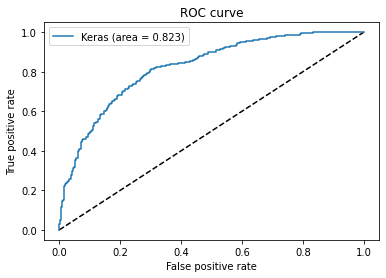

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
#For retraining
#model2.fit(X_train0,Y_train,batch_size=1024, epochs=20, validation_data=(X_valid0,Y_valid))